In [1]:
import numpy as np
import pandas as pd
import scipy
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import scipy.optimize
import time
plt.rcParams["figure.figsize"] = (3,3)

print (time.ctime())

Fri Apr  3 09:54:07 2020


read a data file, store all data in arrays

In [2]:
file1 = "FourIonsTelegraf_100s_W0028_H11-200211-013412-1_cent.csv"
data=np.loadtxt(file1, dtype= float, delimiter=",", usecols = (0,1,2))

#print data
y   = data[:, 0]
x  = data[:, 1]
toA = data[:, 2]

for i in range(0,20):
    print (i, x[i],y[i], toA[i])
    

0 44.0 16.0 221884887040.0
1 173.0 35.0 221890921472.0
2 69.0 145.0 221979102976.0
3 166.0 27.0 222007252480.0
4 202.0 124.0 222071443968.0
5 41.0 19.0 222141341696.0
6 219.0 187.0 222144273408.0
7 242.0 130.0 222145758208.0
8 149.0 72.0 222198915072.0
9 39.0 39.0 222207661824.0
10 127.0 224.0 222220139008.0
11 194.0 154.0 222223526912.0
12 234.0 4.0 222252574208.0
13 161.0 147.0 222293620992.0
14 46.0 135.0 222329322240.0
15 148.0 174.0 222385545216.0
16 120.0 199.0 222461675776.0
17 48.0 79.0 222473999616.0
18 127.0 247.0 222475928832.0
19 0.0 175.0 222575538176.0


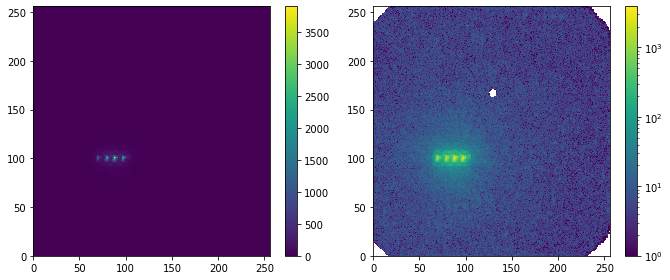

In [3]:
fig, (ax01, ax11) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax01.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)])
fig.colorbar(h[3], ax = ax01)

h = ax11.hist2d(x, y, bins = 256, range = [(0, 256), (0, 256)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax11)
fig.tight_layout()
plt.show()

Text(0, 0.5, 'counts')

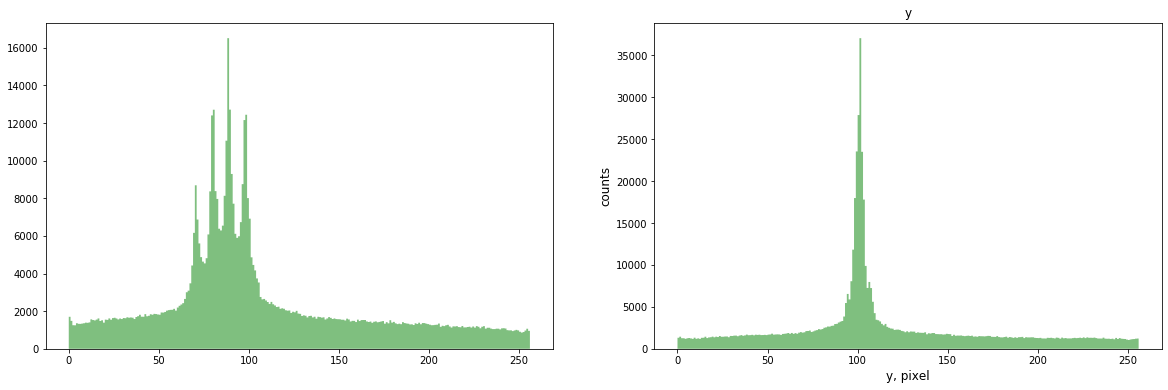

In [18]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 6))

ax0.hist(x, bins = 256, range = (0, 256), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("x", fontsize = 12) # change the title
plt.xlabel('x, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
#plt.xlim(50, 150)

ax1.hist(y, bins = 256, range = (0, 256), color = 'g', alpha=0.5, histtype = 'stepfilled')
plt.title("y", fontsize = 12) # change the title
plt.xlabel('y, pixel',fontsize = 12)
plt.ylabel('counts',fontsize = 12)
#plt.xlim(50, 150)

Investigate 2 neighbour ions considering that corosstalk appers only between neighbour ions

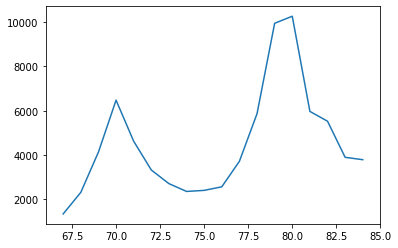

In [6]:
x1 = []; y1 = []; tof1 = []

px0min = 66;  px0max = 85; py0min = 90; py0max = 110; 

for i in range(len(x)-1):
    if (i-(i/10000)*10000 == 1): 
        print (i, time.ctime())
    if ( px0min < x[i] < px0max and py0min < y[i] < py0max): 
        x1.append(x[i])
        y1.append(y[i])
        tof1.append(toA[i]/4096.*25.)
        
x1.sort()
x1r = []
count = []
curr = 0
for idx, val in enumerate(x1):
    if (idx != 0 and val == x1[idx-1]):
        curr = curr + 1
    else:
        if (curr != 0):
            x1r.append(x1[idx-2])
            count.append(curr)
        curr = 1
if (curr != 0):
    x1r.append(x1[-1])
    count.append(curr)
  
    
plt.xlim(px0min,px0max)
plt.plot(x1r, count)

Fitting 2 ions with 2 Gaussian                                     

x_mean1 = 70.12118758592567 x_mean2 = 79.63893485162345 sigma1 = 0.8044591649227159 sigma2 = 1.3677168890108893 ampl1 =  3841.7626914318557 ampl2 =  7593.2364410522805 c =  2641.525744204059


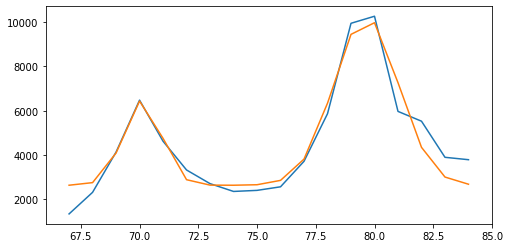

In [7]:
#Fitting with Gaussian

# guess parameters, frequency is taken from FFT

#def guess_f (count1):
#    count_max = np.amax(count1)
#    idx1 = 0
#    for idx, val in enumerate(count1):
#        if (count1[idx] == count_max):
#            idx1 = idx
#            print(idx1,count1[idx1])
#
#    return (idx1)

#guess_meanx = x0r1[guess_f(count1)]
guess_meanx1 = 70
guess_meanx2 = 80
#print(guess_meanx)
guess_sigma1 = 1
guess_sigma2 = 1.5
guess_amp1 = 3000
guess_amp2 = 3000
guess_c = 2000
#guess_c = np.amin(count1)
guess  = np.array([guess_meanx1,guess_meanx2,guess_sigma1,guess_sigma2,guess_amp1,guess_amp2,guess_c])

def gaussian(x, xm1, xm2, sigma1, sigma2, A1, A2, c): return np.absolute(A1)*np.exp(-np.power((x-xm1)/sigma1,2)/2) + np.absolute(A2)*np.exp(-np.power((x-xm2)/sigma2,2)/2)+ c

popt1, pcov1 = scipy.optimize.curve_fit(gaussian, x1r, count, p0=guess, maxfev = 50000)

print ('x_mean1 =', popt1[0],'x_mean2 =', popt1[1], 'sigma1 =', popt1[2],'sigma2 =', popt1[3], 'ampl1 = ', popt1[4],'ampl2 = ', popt1[5], 'c = ', popt1[6])

data_fit = gaussian(x1r, *popt1)

plt.figure(figsize=(8, 4))
plt.xlim(px0min,px0max)
plt.plot(x1r, count)
plt.plot(x1r, data_fit)


In [37]:
# https://datascienceplus.com/understanding-the-covariance-matrix/
variance_string = (
    f" Variances: \n"
    f"Mean x1 = {(pcov1[0])[0]:.3f} \n"
    f"Mean x2 = {(pcov1[1])[1]:.3f} \n"
    f"Mean sigma1 = {(pcov1[2])[2]:.4f} \n"
    f"Mean sigma2 = {(pcov1[3])[3]:.4f} \n"
    f"Mean ampl1 = {(pcov1[4])[4]:.0f} \n"
    f"Mean ampl2 = {(pcov1[5])[5]:.0f} \n"
    f"Mean c = {(pcov1[6])[6]:.0f} \n"
    )
print(variance_string)

 Variances: 
Mean x1 = 0.046 
Mean x2 = 0.019 
Mean sigma1 = 0.0472 
Mean sigma2 = 0.0265 
Mean ampl1 = 785918 
Mean ampl2 = 503788 
Mean c = 110253 



the second pair of ions

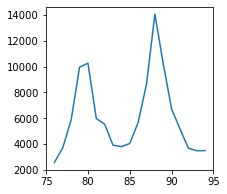

In [41]:
x2 = []; y2 = []; tof2 = []

px1min = 75;  px1max = 95; py1min = 90; py1max = 110; 

for i in range(len(x)-1):
    if (i-(i/10000)*10000 == 1): 
        print (i, time.ctime())
    if ( px1min < x[i] < px1max and py1min < y[i] < py1max): 
        x2.append(x[i])
        y2.append(y[i])
        tof2.append(toA[i]/4096.*25.)
        
x2.sort()
x2r = []
count2 = []
curr = 0
for idx, val in enumerate(x2):
    if (idx != 0 and val == x2[idx-1]):
        curr = curr + 1
    else:
        if (curr != 0):
            x2r.append(x2[idx-2])
            count2.append(curr)
        curr = 1
if (curr != 0):
    x2r.append(x2[-1])
    count2.append(curr)
  
    
plt.xlim(px1min,px1max)
plt.plot(x2r, count2)

Fitting the second pair of ions with 2 Gaussian

x_mean1 = 79.56639830390971 x_mean2 = 88.16671526300311 sigma1 = 1.0170751158297568 sigma2 = 1.127992767880244 ampl1 =  7086.790883742423 ampl2 =  9547.006881171685 c =  3771.434811177233


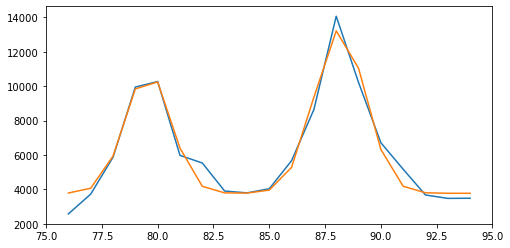

In [29]:
guess_meanx1 = 80
guess_meanx2 = 88
#print(guess_meanx)
guess_sigma1 = 1
guess_sigma2 = 2
guess_amp1 = 10000
guess_amp2 = 14000
guess_c = 3000
#guess_c = np.amin(count1)
guess  = np.array([guess_meanx1,guess_meanx2,guess_sigma1,guess_sigma2,guess_amp1,guess_amp2,guess_c])

def gaussian(x, xm1, xm2, sigma1, sigma2, A1, A2, c): return np.absolute(A1)*np.exp(-np.power((x-xm1)/sigma1,2)/2) + np.absolute(A2)*np.exp(-np.power((x-xm2)/sigma2,2)/2)+ c

popt1, pcov1 = scipy.optimize.curve_fit(gaussian, x2r, count2, p0=guess, maxfev = 50000)

print ('x_mean1 =', popt1[0],'x_mean2 =', popt1[1], 'sigma1 =', popt1[2],'sigma2 =', popt1[3], 'ampl1 = ', popt1[4],'ampl2 = ', popt1[5], 'c = ', popt1[6])

data_fit = gaussian(x2r, *popt1)

plt.figure(figsize=(8, 4))
plt.xlim(px1min,px1max)
plt.plot(x2r, count2)
plt.plot(x2r, data_fit)

the last pair of ions

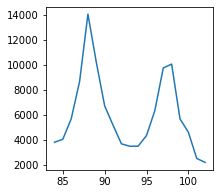

In [31]:
x3 = []; y3 = []; tof3 = []

px2min = 83;  px2max = 103; py2min = 90; py2max = 110; 

for i in range(len(x)-1):
    if (i-(i/10000)*10000 == 1): 
        print (i, time.ctime())
    if ( px2min < x[i] < px2max and py2min < y[i] < py2max): 
        x3.append(x[i])
        y3.append(y[i])
        tof3.append(toA[i]/4096.*25.)
        
x3.sort()
x3r = []
count3 = []
curr = 0
for idx, val in enumerate(x3):
    if (idx != 0 and val == x3[idx-1]):
        curr = curr + 1
    else:
        if (curr != 0):
            x3r.append(x3[idx-2])
            count3.append(curr)
        curr = 1
if (curr != 0):
    x3r.append(x3[-1])
    count3.append(curr)
  
    
plt.xlim(px2min,px2max)
plt.plot(x3r, count3)

Fitting the last pair of ions

x_mean1 = 88.17316529618095 x_mean2 = 97.46683740652031 sigma1 = 1.2040631346464368 sigma2 = 1.0973279570852694 ampl1 =  9677.499295675974 ampl2 =  7082.610277803951 c =  3457.346026880684


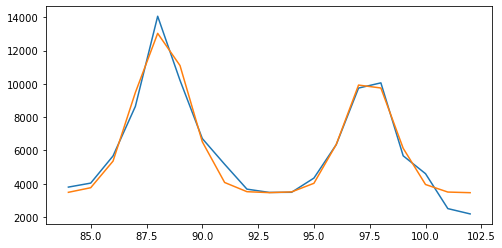

In [33]:
guess_meanx1 = 87
guess_meanx2 = 97
#print(guess_meanx)
guess_sigma1 = 1
guess_sigma2 = 2
guess_amp1 = 14000
guess_amp2 = 10000
guess_c = 3000
#guess_c = np.amin(count1)
guess  = np.array([guess_meanx1,guess_meanx2,guess_sigma1,guess_sigma2,guess_amp1,guess_amp2,guess_c])

def gaussian(x, xm1, xm2, sigma1, sigma2, A1, A2, c): return np.absolute(A1)*np.exp(-np.power((x-xm1)/sigma1,2)/2) + np.absolute(A2)*np.exp(-np.power((x-xm2)/sigma2,2)/2)+ c

popt1, pcov1 = scipy.optimize.curve_fit(gaussian, x3r, count3, p0=guess, maxfev = 50000)

print ('x_mean1 =', popt1[0],'x_mean2 =', popt1[1], 'sigma1 =', popt1[2],'sigma2 =', popt1[3], 'ampl1 = ', popt1[4],'ampl2 = ', popt1[5], 'c = ', popt1[6])

data_fit = gaussian(x3r, *popt1)

plt.figure(figsize=(8, 4))
plt.xlim(px2min,px2max)
plt.plot(x3r, count3)
plt.plot(x3r, data_fit)